In [1392]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve


%matplotlib notebook

In [1393]:
from sympy import *
init_printing()

In [1394]:
M0,x=symbols("M_0 x",real=True)
D=Symbol('D',positive=True)
t=Symbol('t',positive=True)

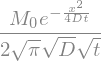

In [1395]:
Csoln=M0/sqrt(4*pi*D*t) * exp(-x**2 / (4*D*t))
Csoln

In [1396]:
mom0=integrate(Csoln,(x,-oo,oo))
mom0

In [1397]:
mom1=integrate(Csoln*x,(x,-oo,oo))
mom1

In [1398]:
mom2=integrate(Csoln*x**2,(x,-oo,oo))
mom2

Centroid is $m_1/m_0$:

In [1399]:
mom1/mom0

Variance is $m_2/m_0$, with the variance calculated relative to x=centroid

In [1400]:
mom2/mom0

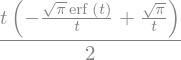

In [1401]:
term1=integrate( exp(-x**2), (x,t,oo))
term1

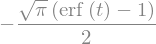

In [1402]:
term1.expand().factor()

<IPython.core.display.Javascript object>


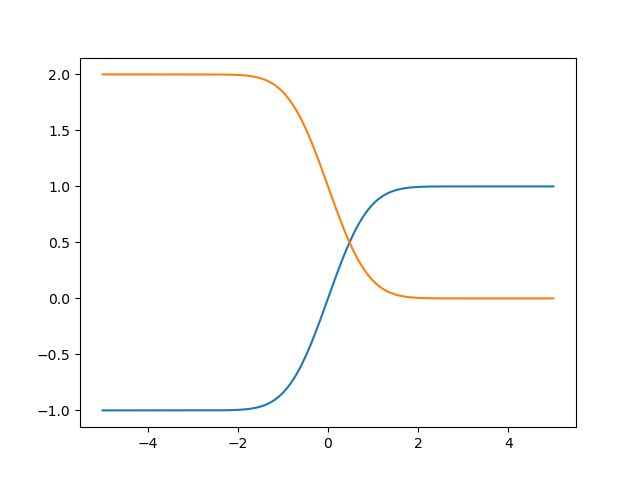

In [1405]:
from scipy.special import erf, erfc

y=np.linspace(-5,5,200)

plt.figure()
plt.plot(y,erf(y),label='erf')
plt.plot(y,erfc(y),label='erfc')



In [1406]:
xp=Symbol("x'")
xp

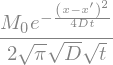

In [1407]:
c_exp=M0/sqrt(4*pi*D*t)* exp(-(x-xp)**2/(4*D*t))
c_exp

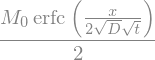

In [1408]:
integrate( c_exp, (xp,-oo,0))

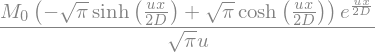

In [1412]:
# Continuous release
# naive approach: integrate the point release in time out to 
# infinity, representing overlapping releases.
# 
u=Symbol('u',real=True,positive=True)
xpos=Symbol('x',real=True,positive=True)

soln=integrate( M0/sqrt(4*pi*D*t)* exp(-(xpos-u*t)**2/(4*D*t)), (t,0,oo))
soln

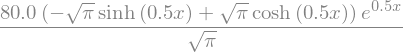

In [1413]:
eq1.subs(u,0.05)

<IPython.core.display.Javascript object>


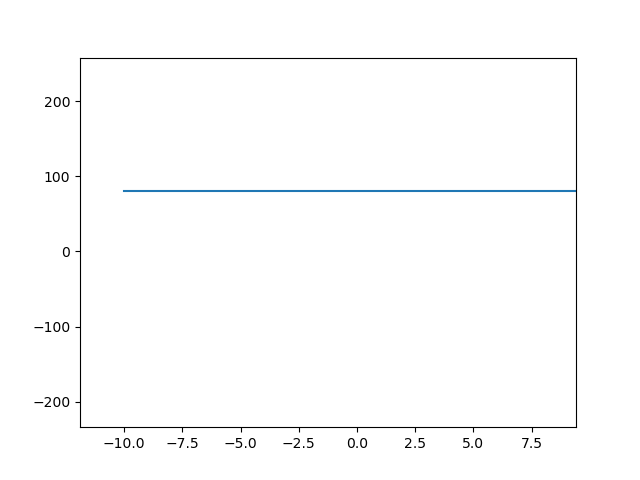

In [1414]:
mdot=4.0 # g/m2 /s
Dnum=0.05 # m2/s

eq1=soln.subs(u,0.05).subs(D,0.05).subs(M0,4)

y=np.linspace(-10,10,100)

c_y=[ eq1.subs(xpos,val).evalf() for val in y]

plt.figure()
plt.plot(y,c_y)

<IPython.core.display.Javascript object>


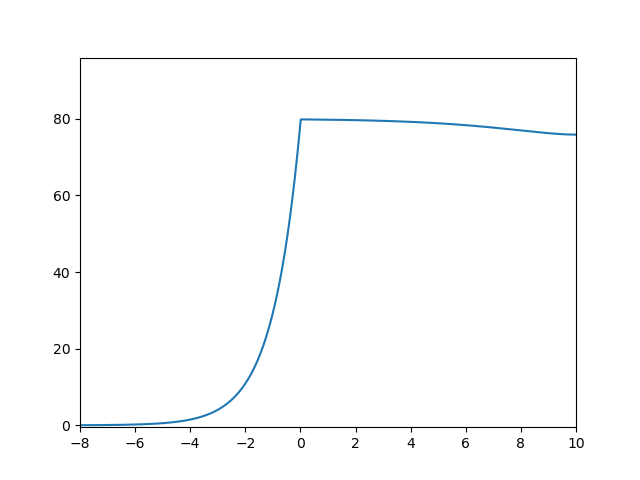

In [1459]:
N=1001
dt=0.4
mdot=4.0 # g/m2 /s
Dnum=0.05 # m2/s
unum=0.05 # m/s

C0=mdot/unum # This is the correct value, and there is a bug below.

x=np.linspace(-8,10,N)
Cnum=np.zeros_like(x)

dx=x[1]-x[0]
fig,ax=plt.subplots()

l=ax.plot(x,Cnum)[0]

ax.axis(xmin=x[0],xmax=x[-1],ymin=-0.5,ymax=1.2*C0) ;

In [1460]:
ff=Dnum*dt/dx**2
d0=(1+2*ff)*np.ones(N)
dp1=-ff*np.ones(N)
dp1[1]*=2
dm1=-ff*np.ones(N)
dm1[-2:]*=2 
mat_imp=spdiags( [dm1,d0,dp1], [-1,0,1], N, N).tocsr()

xedge=np.r_[x-dx/2,x[-1]+dx/2]

for _ in range(1000):
    # Advection:
    Cnum=np.interp(x,x+dt*unum,Cnum,left=0,right=0)
    # Source w/advection
    # add Csrc=mdot/u for the interval [0,u*dt]
    # integrate to get the cumulative distribution, then interpolate
    # and diff to get discrete distribution:
    # for x<0, cdf is 0.
    # over [0,u*dt] this should ramp up to mdot*dt 
    # Make an x coord array for the edge of the control volumes
    # The cumulative mass over [-inf,x_i] for each x_i in xedge,
    # for mass released over [0,dt]
    cmdf_x=np.interp( xedge, [0,unum*dt], [0,mdot*dt])
    mdf_x=np.diff(cmdf_x) # mass per CV
    Cnum[:]+=mdf_x/dx # concentratino per CV

    # Diffusion:
    Cnum=sparse.linalg.spsolve(mat_imp,Cnum)

    l.set_ydata(Cnum)
    

In [1444]:
sel=x<=0
ax.plot(x[sel],C0*np.exp(unum*x[sel]/Dnum),'k--')

Reasoning:
---

At steady state, for $x \neq 0$,

$$ u \frac{dC}{dx} = D \frac{d^2 C}{dx^2}$$   


Integrate both sides...

$$ uC = D\frac{dC}{dx} + A $$

Can't integrate again, as $C=C(x)$.
One solution is that $C$ is constant, $dC/dx=0$, and we solve for $A$. This works for the +x side.
One the -x side, we can assume that as $x\rightarrow-\infty$, $C\rightarrow 0$. If $C$ goes to zero, then advective flux goes to zero and the balancing  

Consider a control volume.  A control volume goes arbitrarily far out to -x, and stops at x<0. This box has no flux in on the left, no internal sources, and a steady mass.  So the flux on the right side of the box must be 0. So for any point x<0, advective flux is to the right ($J_A >= 0$) and it must be exactly balanced by diffusive flux ($J_D=-J_A<=0$)

For $x<0$:
$$ uC=D \frac{dC}{dx}$$

We can solve this and find that $C(x)=C(0) e^{ux/D}$

If the right side of the CV is at $x>0$, then the box includes a source, but still no flux from the left. So the net flux out the right side must be equal the source.

$$uC -D \frac{dC}{dx} = \dot{m}/a$$

One solution is that $C$ is constant, the flux is entirely advective.

This is a first order ODE. So we need 1 BC. 

Could say that as $x\rightarrow \infty$, advection dominates, and if it's just a point source and advection then we can solve directly for the right BC. That feels a bit weak, but probably okay.

Can do a bit better than that:
$$C - \frac{\dot{m}}{au} = \frac{D}{u} \frac{dC}{dx} $$

$$ \int dx = \frac{D}{u} \int \frac{dC}{C- \dot{m}/au}$$

$$ x + B = \frac{D}{u} \ln [ C-\dot{m}/au ]$$

$$ C = B' e^\frac{ux}{D} + \dot{m}/au $$

We have a growing exponential and a constant. Knowing that as $x$ goes to $\infty$ $C$ is finite and nonzero, then $B'=0$